In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [ ]:
dict_dfs, dict_dfs_species, _ = dlu.load_metadata(drop_duplicates=True, create_validation_set=False)

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [15]:
print(dict_dfs.keys())
dict_dfs['df_test_pa']

dict_keys(['df_train_pa', 'df_train_po', 'df_test_pa'])


,lng,lat,year,surveyId
0,10.033550,57.120810,2019,642
1,7.333000,46.229970,2019,1792
2,1.843658,42.580060,2018,3256
3,11.720090,46.261490,2021,3855
4,9.361870,55.902450,2017,4889
...,...,...,...,...
14779,4.148978,43.989024,2021,5000929
14780,3.523861,43.700529,2021,5000922
14781,3.562852,43.864276,2021,5000927
14782,3.557167,43.864581,2021,5000925



----
df_train_pa: 88987 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 88987
Unique species: 5016

----
df_train_po: 3845533 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 3845533
Unique species: 9709

----
df_test_pa: 14784 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 14784
Unique species: NA


/home/thijs/anaconda3/envs/geo_tor/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thijs/anaconda3/envs/geo_tor/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thijs/anaconda3/envs/geo_tor/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thijs/anaconda3/envs/geo_tor/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

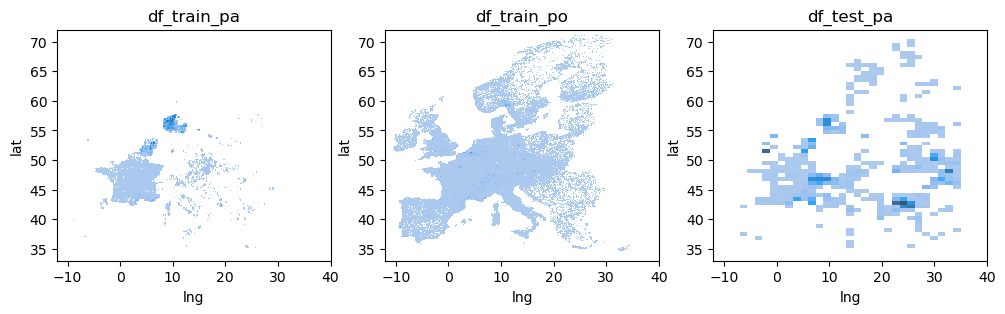

In [ ]:
for key, df in dict_dfs.items():
    print('\n----')
    print(f'{key}: {df.shape[0]} samples')
    print(df.columns)
    n_unique_samples = df['surveyId'].nunique()
    if 'test' not in key:
        n_unique_species = dict_dfs_species[key + '_species']['speciesId'].nunique()
    else:
        n_unique_species = 'NA'
    print(f'Unique surveys: {n_unique_samples}')
    print(f'Unique species: {n_unique_species}')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
# ax = ax.flatten()
for i, key in enumerate(dict_dfs.keys()):
    df = dict_dfs[key]
    sns.histplot(data=df, x='lng', y='lat', ax=ax[i])
    ax[i].set_title(key)
    ax[i].set_xlim([-12, 40])
    ax[i].set_ylim([33, 72])

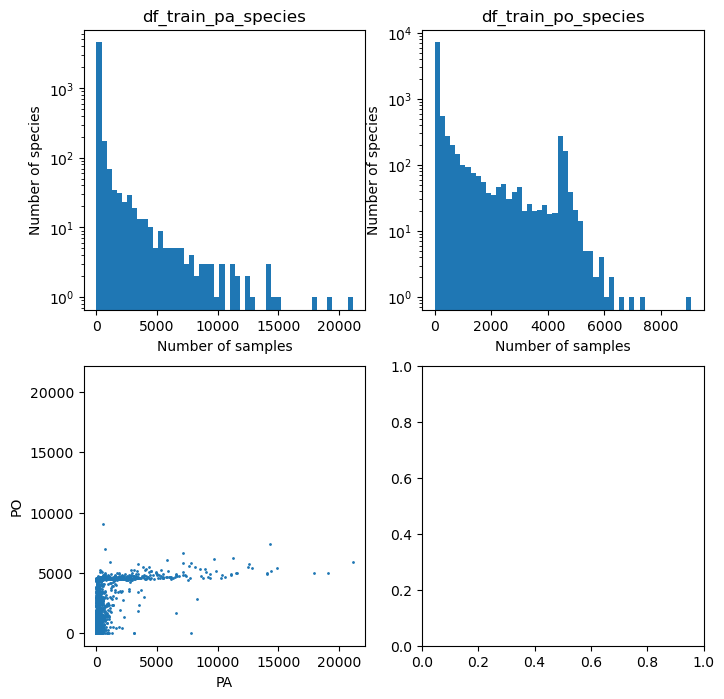

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

for iplot, name in enumerate(['df_train_pa_species', 'df_train_po_species']):
    curr_ax = ax[0, iplot]
    curr_ax.hist(dict_dfs_species[name].value_counts('speciesId').values, bins=50)
    curr_ax.set_yscale('log')
    curr_ax.set_title(name)
    curr_ax.set_xlabel('Number of samples')
    curr_ax.set_ylabel('Number of species')

curr_ax = ax[1, 0]
val_counts_pa = dict_dfs_species['df_train_pa_species'].value_counts('speciesId')
val_counts_po = dict_dfs_species['df_train_po_species'].value_counts('speciesId')
joint_counts_overlap = np.zeros((val_counts_pa.shape[0], 2))
for i, species_id in enumerate(val_counts_pa.index):
    joint_counts_overlap[i, 0] = val_counts_pa[species_id]
    joint_counts_overlap[i, 1] = val_counts_po.get(species_id, 0)

curr_ax.scatter(joint_counts_overlap[:, 0], joint_counts_overlap[:, 1], s=1)
curr_ax.set_xlabel('PA')
curr_ax.set_ylabel('PO')
# curr_ax.set_xlim([-100, 5000])
# curr_ax.set_ylim([-100, 5000])
rfv.equal_xy_lims(curr_ax)

## Thoughts on data:
- *elevation*: clean except 35 surveys -> fixed
- *landcover*: clean, categorical
- *climate_av*: clean, 20 features.
- *climate_monthly*: clean, 4 feat * 12 months * 20 years = 900 features
- *human_footprint*: clean except few cols, can be excluded. 10 features left (5 for 1992, 5 for 2010)
- *soilgrids*: clean except for 7500-9000 surveys. 9 features.
- *landsat timeseries*: clean except for 2018 onwards (can be excluded). 4 quartes * 17 years = 68 features. * 6 bands = 400 features
- *

In [100]:
example_sat_im = dlu.load_sat_patch(surveyId=212)

In [19]:
df_all = dlu.load_multiple_env_raster(mode='train',
    list_env_types=['elevation', 'landcover', 'climate_av', 'landsat'])
df_all

Nans in elevation data: 35. Manually fixing now.
Nans in elevation data fixed


,surveyId,Elevation,LandCover-1,LandCover-2,LandCover-3,LandCover-4,LandCover-5,LandCover-6,LandCover-7,LandCover-8,...,2015_3_swir2,2015_4_swir2,2016_1_swir2,2016_2_swir2,2016_3_swir2,2016_4_swir2,2017_1_swir2,2017_2_swir2,2017_3_swir2,2017_4_swir2
0,212,47.0,8.0,8.0,4.0,1.0,1.0,87.0,87.0,87.0,...,18.0,10.0,13.0,19.0,18.0,12.0,7.0,15.0,16.0,10.0
1,222,6.0,12.0,12.0,1.0,6.0,7.0,94.0,95.0,94.0,...,28.0,26.0,20.0,20.0,30.0,27.0,22.0,23.0,27.0,27.0
2,243,10.0,5.0,5.0,7.0,1.0,1.0,92.0,93.0,93.0,...,11.0,11.0,6.0,1.0,8.0,15.0,9.0,10.0,8.0,15.0
3,324,116.0,14.0,14.0,4.0,4.0,4.0,84.0,88.0,84.0,...,15.0,38.0,35.0,47.0,17.0,23.0,40.0,42.0,15.0,35.0
4,333,84.0,14.0,14.0,4.0,1.0,1.0,78.0,82.0,78.0,...,64.0,42.0,44.0,52.0,32.0,52.0,33.0,57.0,21.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88982,3919553,23.0,12.0,12.0,1.0,6.0,7.0,99.0,99.0,99.0,...,21.0,25.0,27.0,29.0,25.0,23.0,29.0,32.0,23.0,21.0
88983,3919592,138.0,9.0,9.0,4.0,4.0,4.0,82.0,82.0,82.0,...,14.0,10.0,13.0,16.0,12.0,12.0,9.0,14.0,13.0,11.0
88984,3919620,37.0,12.0,12.0,1.0,6.0,7.0,91.0,92.0,91.0,...,25.0,28.0,47.0,36.0,25.0,31.0,35.0,27.0,33.0,27.0
88985,3919640,131.0,1.0,1.0,7.0,1.0,1.0,99.0,99.0,99.0,...,11.0,8.0,4.0,11.0,12.0,7.0,5.0,13.0,16.0,7.0


In [22]:
tmp = dlu.create_full_pa_ds(val_or_test='test', transform_pca=True)
tmp[0][0]

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species
Nans in elevation data: 35. Manually fixing now.
Nans in elevation data fixed
Nans in elevation data fixed


,lng,lat,year,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8
0,3.099038,43.134956,2021,-0.977093,6.715387,2.122547,-2.592209,-0.887655,0.037824,1.475983,1.276905,0.467153
1,9.884560,56.912140,2017,-2.200462,-2.142628,1.419396,-0.332439,0.365504,-0.172474,0.307091,-0.386375,0.153065
2,8.256020,55.637050,2019,0.016654,1.116910,-3.249199,0.487071,-2.360150,2.768693,-0.843893,1.092335,0.178744
3,-0.402590,43.505630,2018,2.213390,2.988380,3.107610,0.544759,-1.000509,-2.607380,0.946428,-0.333238,-0.604285
4,-0.517360,45.806430,2017,1.402726,3.459225,1.547053,0.529845,-0.574520,-2.167771,1.838616,0.786929,-0.867817
...,...,...,...,...,...,...,...,...,...,...,...,...
88982,10.327990,57.305850,2018,-3.041478,-2.337994,0.954562,1.214305,-0.956538,1.370379,-0.113201,-0.618866,-0.018630
88983,15.003900,55.090170,2017,-2.305258,-0.285441,-2.164850,1.052935,-0.004605,1.066884,-0.218040,1.381733,0.942900
88984,8.935060,55.461500,2018,-0.450887,-2.090257,1.836106,1.373577,0.175376,0.410077,0.629497,-0.243554,-0.287883
88985,17.252948,53.901434,2021,1.762464,-0.510589,-3.089691,-4.678666,0.181470,2.207807,-1.109205,0.452890,-0.561411


In [28]:
tmp[2]

array([0.21329657, 0.20470439, 0.14766458, 0.0917503 , 0.08668874,
       0.06273567, 0.04537679, 0.04042772, 0.02191476])

In [75]:
import timm 
import torchgeo 
from torchgeo.models import ResNet18_Weights
import torch
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
print(weights.meta)
model = timm.create_model('resnet18', in_chans=weights.meta['in_chans'], num_classes=16)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

{'dataset': 'SSL4EO-S12', 'in_chans': 3, 'model': 'resnet18', 'publication': 'https://arxiv.org/abs/2211.07044', 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12', 'ssl_method': 'moco'}


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [76]:
model.forward(torch.tensor(tmp_img).permute(2, 0, 1).unsqueeze(0).float())

tensor([[-0.0099, -0.0224,  0.0190,  0.0753, -0.0348, -0.0110, -0.0119, -0.0232,
          0.0328, -0.0029,  0.0595,  0.0226, -0.0535, -0.0460, -0.0186,  0.0068]],
       grad_fn=<AddmmBackward0>)

In [79]:
weights.SENTINEL2_RGB_MOCO.__dict__

{'_value_': Weights(url='https://hf.co/torchgeo/resnet18_sentinel2_rgb_moco/resolve/e1c032e7785fd0625224cdb6699aa138bb304eec/resnet18_sentinel2_rgb_moco-e3a335e3.pth', transforms=AugmentationSequential(
   (augs): AugmentationSequential(
     (Resize_0): Resize(output_size=256, p=1.0, p_batch=1.0, same_on_batch=True, size=256, side=short, resample=bilinear, align_corners=True, antialias=False)
     (CenterCrop_1): CenterCrop(p=1.0, p_batch=1.0, same_on_batch=True, resample=bilinear, cropping_mode=slice, align_corners=True, size=(224, 224), padding_mode=zeros)
     (Normalize_2): Normalize(p=1.0, p_batch=1.0, same_on_batch=True, mean=0, std=10000)
   )
 ), meta={'dataset': 'SSL4EO-S12', 'in_chans': 3, 'model': 'resnet18', 'publication': 'https://arxiv.org/abs/2211.07044', 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12', 'ssl_method': 'moco'}),
 '_name_': 'SENTINEL2_RGB_MOCO',
 '__objclass__': <enum 'ResNet18_Weights'>}